# Intraday Volatility Forecasting and Portfolio Risk Management Using GARCH for Indian Bank Stocks.

In [1]:
"""
    Title: GARCH Trading Strategy
    Description: This is GARCH volatility forecasting model, to forecast volatility, 
    adjust portfolio VaR and CVaR, along with minimizing drawdown and maximizing strategy returns
"""

'\n    Title: GARCH Trading Strategy\n    Description: This is GARCH volatility forecasting model, to forecast volatility, \n    adjust portfolio VaR and CVaR, along with minimizing drawdown and maximizing strategy returns\n'

##  STEP 1 : Importing Library

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm
import yfinance as yf
import plotly.express as px
import warnings
from arch.univariate import base
warnings.filterwarnings("ignore", category=base.ConvergenceWarning)
import seaborn as sns


## STEP 2:  Data Import and Preprocessing

I am making a portfolio of 5 banking stocks,
- 1 of which is large cap( HDFC BANK),
- 2 of which is mid cap(AU BANK and BANDHAN BANK)
- 2 is of small cap(EQUITAS BANK & FEDERAL BANK).
Just to diversify the volatility,
- All 5 are equally weighted
- I am taking 2 months of data, from 7th August 2025 to 3rd October 2025 of Closing Price data of above stocks because of Yahoo Finance restrictions, for 5 minute candles. 

In [96]:
# Define tickers
tickers = [
    "HDFCBANK.NS",
    "AUBANK.NS",
    "BANDHANBNK.NS",
    "EQUITASBNK.NS",
    "FEDERALBNK.NS"
]

# Download 5-min data - max 60 days due to Yahoo limit
def download_5min_data(tickers, period='60d', interval='5m'):
    data_dict = {}
    for ticker in tickers:
        print(f"Downloading {ticker} 5-min data...")
        data = yf.download(ticker, period=period, interval=interval)
        if data.empty:
            print(f"No data for {ticker}")
        else:
            data_dict[ticker] = data
    return data_dict

data_5min = download_5min_data(tickers)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [97]:
data_5min

{'HDFCBANK.NS': Price                            Close         High          Low         Open  \
 Ticker                     HDFCBANK.NS  HDFCBANK.NS  HDFCBANK.NS  HDFCBANK.NS   
 Datetime                                                                        
 2025-07-11 03:45:00+00:00  1000.900024  1001.500000   999.599976  1000.599976   
 2025-07-11 03:50:00+00:00  1001.400024  1001.400024  1000.250000  1000.650024   
 2025-07-11 03:55:00+00:00  1001.500000  1002.299988  1001.200012  1001.400024   
 2025-07-11 04:00:00+00:00  1000.750000  1001.599976  1000.549988  1001.599976   
 2025-07-11 04:05:00+00:00  1001.450012  1001.450012  1000.549988  1000.750000   
 ...                                ...          ...          ...          ...   
 2025-10-03 09:35:00+00:00   965.799988   966.049988   965.549988   965.750000   
 2025-10-03 09:40:00+00:00   965.250000   965.950012   965.200012   965.799988   
 2025-10-03 09:45:00+00:00   964.049988   965.200012   964.000000   965.200012   
 

## STEP 3: Rolling GARCH Model Development

The GARCH model (Generalized AutoRegressive Conditional Heteroskedasticity) is used to estimate and forecast time-varying volatility in financial returns. Here, we are fitting a rolling GARCH(2,2) model on past windows of returns to capture volatility clustering and generate annualized volatility forecasts. The model can be tweaked by changing p and q, which control autocorrelation effects, the distribution type (skewt, normal, or t), and the optimizer (ADAM or LBFGS) for better fitting.

In [82]:
# Function to calculate rolling GARCH volatility forecast
def rolling_garch_forecast(returns_series, window):  ## Window of 1200, because total data is just 3200 points
    vols = [np.nan] * window
    for i in range(window, len(returns_series)):
        window_returns = returns_series[i-window:i]
        try:
            model = arch_model(window_returns, vol='GARCH', p=2, q=2, dist='skewt')## dist can be normal or t
            model_fit = model.fit(disp='off',optimizer='lbfgs')## 'lbfgs',adam''
            forecast_var = model_fit.forecast(horizon=1).variance.values[-1, 0]
            forecast_vol = np.sqrt(forecast_var) * np.sqrt(18900)  # annualize for 5 min of data and 252 trading days
        except:
            forecast_vol = np.nan
        vols.append(forecast_vol)
    return pd.Series(vols, index=returns_series.index)

## Step 4: Implementing the strategy on the log returns data and Computing Trading Signal Generation Based on Forecast vs. Realized Volatility

In [107]:
results = {}
for ticker, df in data_5min.items():
    print(f"Processing {ticker}...")

    ## Step 4.1 Cleaning the data 
    df = df.dropna()
    
    # Step 4.2 Calculating log returns
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()    

    ### Step 4.3 Calculate realised volatility (rolling std deviation, annualised)
    realized_vol_window = 50  # Suitable for intraday 5-min data
    df['realized_vol'] = df['log_returns'].rolling(realized_vol_window).std() * np.sqrt(18900)

    ### Step 4.4 Calcuating rolling GARCH volatility forecast
    garch_window = 900 ## Suitable for data with 3200 values
    df['garch_vol_forecast'] = rolling_garch_forecast(df['log_returns'],window = garch_window)

    ## Step 4.5 Generate Trading signals based on volatility comparison
    ## Signal: long(1) if forecast vol > realised vol else short (-1)
    df['signal'] = np.where(df['garch_vol_forecast'] > df['realized_vol'],1,-1) 


    ## Step 4.6 Calculate the strategy and benchmark returns 

    ## Strategy returns with lagged signal to avoid lookahead bias 
    df['strategy_returns'] = df['log_returns'] * df['signal'].shift(1)

    ## Calculate cumulative returns 
    df['strategy_cum_returns'] = np.exp(df['strategy_returns'].cumsum()) - 1
    df['benchmark_cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1

    ## Step 4.7 Define max drawdown helper fucntion and compute performance metrics
    def max_drawdown(cum_returns):
        peak = cum_returns.cummax()
        drawdown = (cum_returns - peak) / peak
        return drawdown.min()


     ## Step 4.8 Count trades
    number_of_positive_trades = int((df['strategy_returns'] > 0).sum())
    number_of_negative_trades = int((df['strategy_returns'] < 0).sum())

    ## Important Metrics
    annualized_return = df['strategy_returns'].mean() * 18900
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(18900)
    sharpe_ratio = annualized_return / annualized_volatility
    max_dd = max_drawdown(df['strategy_cum_returns'] + 1)
    calmar_ratio = annualized_return / abs(max_dd)

    print(f"{ticker} Performance Metrics:")
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_dd:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")

    print(f"Number of Positive Trades: {number_of_positive_trades}")
    print(f"Number of Negative Trades: {number_of_negative_trades}")
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    results[ticker] = df




Processing HDFCBANK.NS...
HDFCBANK.NS Performance Metrics:
--------------------------------------------------------------------
--------------------------------------------------------------------
Annualized Return: 0.1647
Annualized Volatility: 0.1389
Sharpe Ratio: 1.1857
Max Drawdown: -0.0383
Calmar Ratio: 4.2996
Number of Positive Trades: 2076
Number of Negative Trades: 2067
--------------------------------------------------------------------
--------------------------------------------------------------------
Processing AUBANK.NS...
AUBANK.NS Performance Metrics:
--------------------------------------------------------------------
--------------------------------------------------------------------
Annualized Return: 0.4872
Annualized Volatility: 0.2755
Sharpe Ratio: 1.7685
Max Drawdown: -0.1007
Calmar Ratio: 4.8366
Number of Positive Trades: 2144
Number of Negative Trades: 2008
--------------------------------------------------------------------
-----------------------------------

### Step 5: Computation of Risk Metrics

In [112]:

# Assume 18900 intervals in a year (if 5-min bars)
annual_factor = 18900

# Create a DataFrame by aligning all stocks' strategy returns on timestamp
strategy_returns_list = [df['strategy_returns'] for df in results.values()]
strategy_returns_df = pd.concat(strategy_returns_list, axis=1)

# Portfolio: equal-weighted average return at each point
portfolio_returns = strategy_returns_df.mean(axis=1)

# Portfolio strategy cumulative return over time
portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1

# Final portfolio return over 2 months
final_portfolio_return = portfolio_cum_return[-1]
print(f"Total Portfolio Return over 2 months: {final_portfolio_return:.4%}")

# Portfolio performance metrics
annualized_return_p = portfolio_returns.mean() * annual_factor
annualized_volatility_p = portfolio_returns.std() * np.sqrt(annual_factor)
sharpe_ratio_p = annualized_return_p / annualized_volatility_p

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

max_dd_p = max_drawdown(portfolio_cum_return + 1)
calmar_ratio_p = annualized_return_p / abs(max_dd)



Total Portfolio Return over 2 months: 9.0905%


In [113]:

# Initialize lists for each metric
metrics_list = []

# Calculate metrics using the same formula as in your processing loop
for ticker, df in results.items():
    annualized_return = df['strategy_returns'].mean() * 18900
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(18900)
    sharpe_ratio = annualized_return / annualized_volatility
    def max_drawdown(cum_returns):
        peak = cum_returns.cummax()
        drawdown = (cum_returns - peak) / peak
        return drawdown.min()
    max_dd = max_drawdown(df['strategy_cum_returns'] + 1)
    calmar_ratio = annualized_return / abs(max_dd)
    metrics_list.append({
        'Ticker': ticker,
        'Return': annualized_return,
        'Volatility': annualized_volatility,
        'Sharpe': sharpe_ratio,
        'Max Drawdown': max_dd,
        'Calmar': calmar_ratio
    })

# Add portfolio metrics to metrics_list
metrics_list.append({
    'Ticker': 'Portfolio',
    'Return': annualized_return_p,
    'Volatility': annualized_volatility_p,
    'Sharpe': sharpe_ratio_p,
    'Max Drawdown': max_dd_p,
    'Calmar': calmar_ratio_p
})

# Final DataFrame with both stocks and portfolio
metrics_df = pd.DataFrame(metrics_list).set_index('Ticker')

In [114]:
metrics_df.round(4)

,Return,Volatility,Sharpe,Max Drawdown,Calmar
Ticker,,,,,
HDFCBANK.NS,0.1647,0.1389,1.1857,-0.0383,4.2996
AUBANK.NS,0.4872,0.2755,1.7685,-0.1007,4.8366
BANDHANBNK.NS,0.3299,0.2325,1.4191,-0.0842,3.9173
EQUITASBNK.NS,0.5304,0.2867,1.8502,-0.1442,3.6775
FEDERALBNK.NS,0.4112,0.1661,2.4759,-0.0589,6.9851
Portfolio,0.3786,0.1266,2.9910,-0.0489,7.7364


- #### Defensive play: HDFCBANK -> lowest volatility, but limited upside.
- #### Star performer: FEDERALBNK -> strong returns, low vol, best Sharpe & Calmar → best risk-adjusted bet.
- #### Growth candidates: EQUITASBNK & AUBANK -> high return potential but risky (big drawdowns).
- #### Balanced: BANDHANBNK -> mid-tier on all metrics, not a standout.

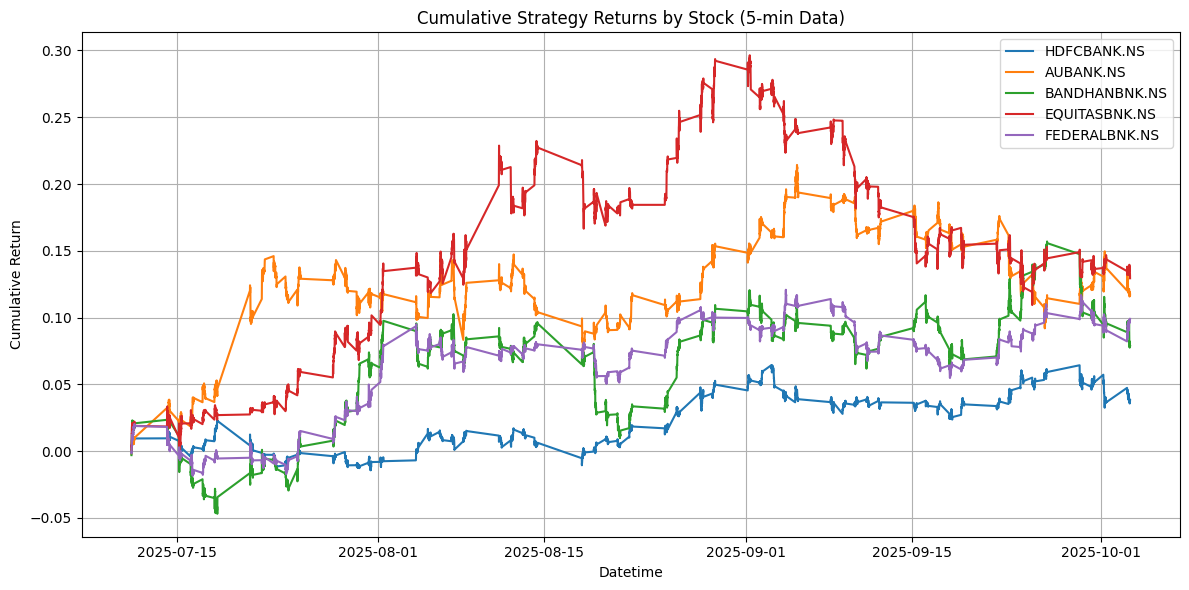

In [115]:
plt.figure(figsize=(12, 6))
for ticker, df in results.items():
    plt.plot(df.index, df['strategy_cum_returns'], label=ticker)
plt.title("Cumulative Strategy Returns by Stock (5-min Data)")
plt.xlabel("Datetime")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

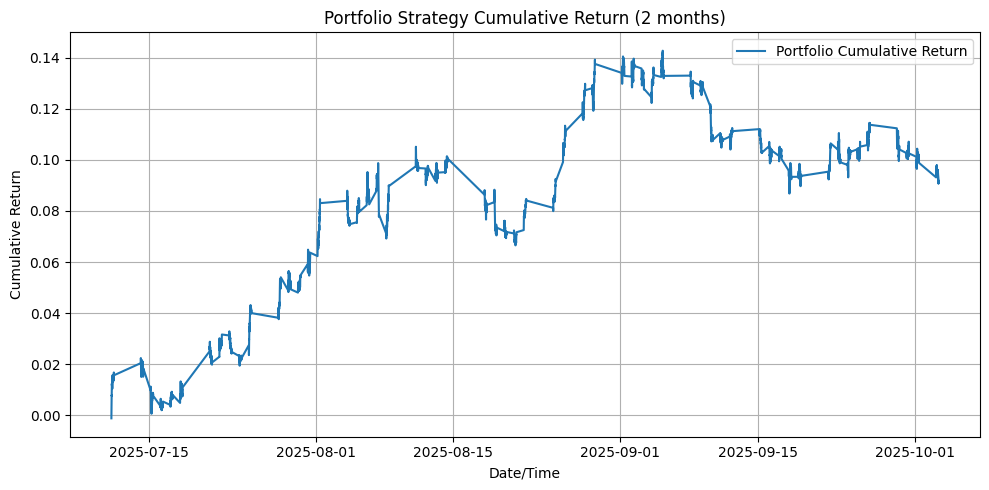

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(portfolio_cum_return, label="Portfolio Cumulative Return")
plt.title("Portfolio Strategy Cumulative Return (2 months)")
plt.xlabel("Date/Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

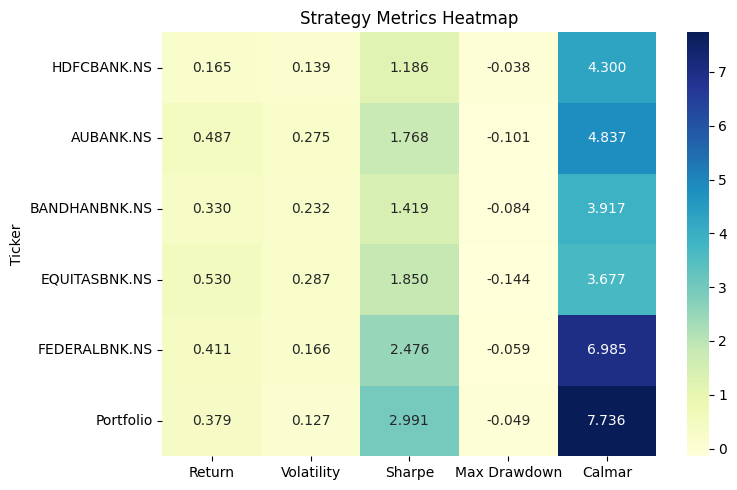

<Figure size 640x480 with 0 Axes>

In [120]:
plt.figure(figsize=(8,5))
sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Strategy Metrics Heatmap")
plt.tight_layout()
plt.show()
# Save the image
plt.savefig("D://ALGO TRADING EPAT//Garch project//strategy_metrics_heatmap.png", dpi=300, bbox_inches="tight")